# Accessing raw measurement data with RAW-CAPTURE

In this we are going to show how to access "raw" measurement data with Quilt.

In [1]:
from pyquil import Program, get_qc

qc = get_qc('Aspen-M-3')

In [2]:
cals = qc.compiler.get_calibration_program()

## Peeking at a MEASURE calibration
We first take a peek at how a measurement operation is specified. We can do this by looking at the corresponding calibration. Below we consider the calibration for `MEASURE 0`.

In [3]:
from pyquil.quilatom import Qubit, Frame
from pyquil.quilbase import Pulse, Capture, DefMeasureCalibration

qubit = Qubit(0)

measure_defn = cals.measure_calibrations[0]

print(measure_defn)

DEFCAL MEASURE 0 addr:
	FENCE 0
	DECLARE q0_unclassified REAL[2]
	PULSE 0 "rf_f12" drag_gaussian(alpha: -1.394451807996698, anh: -190000000, detuning: 0, duration: 4e-8, fwhm: 1e-8, phase: 0, scale: 0.28637132443339525, t0: 2e-8)
	NONBLOCKING PULSE 0 "ro_tx" flat(detuning: 0, duration: 2.08e-6, iq: 1, phase: 0, scale: 0.158489319246111)
	NONBLOCKING CAPTURE 0 "ro_rx" boxcar_kernel(detuning: 0, duration: 2.08e-6, phase: -0.12799541944924012, scale: 1) q0_unclassified[0]
	PRAGMA FILTER-NODE q0_unclassified "{'module':'lodgepole.filters.io','filter_type':'DataBuffer','source':'q0_ro_rx/filter','publish':true,'params':{},'_type':'FilterNode'}"
	PRAGMA LOAD-MEMORY q0_unclassified "q0_unclassified[0]"
	PRAGMA FILTER-NODE q0_classified "{'module':'lodgepole.filters.classifiers','filter_type':'SingleQLinear','source':'q0_ro_rx/filter','publish':false,'params':{'a':[1.0,0.0],'threshold':0.00044068585795624876},'_type':'FilterNode'}"
	PRAGMA FILTER-NODE q0 "{'module':'lodgepole.filters.io','filt

There are a few things note about the above:

1. The basic structure of `MEASURE 0 addr` is to apply a pulse on the `"ro_tx"` frame, and then perform a capture on the corresponding `"ro_rx"` frame.
2. Although the user may perform `MEASURE 0 ro`, the memory location required for this is a bit. Under the hood, `CAPTURE` writes a complex IQ value to the `REAL[2]` region `q0_unclassified`.
3. The wrangling in order to map from `q0_unclassified` to `addr` is controlled through `PRAGMA` operations. These are important for downstream processing and execution of the Quil program. Tamper with them at your own risk!

## RAW-CAPTURE experiments

The value stored in `q0_unclassified` has already been processed on hardware: in particular, it is produced by demodulating a passband signal and then integrating against the `CAPTURE` waveform. What `RAW-CAPTURE` does is give you, the user, access to the raw values of that passband signal. In the following, execute programs with `RAW-CAPTURE`, and plot their results.

Before we begin, it will be useful to get some data associated with the above `MEASURE` calibration. In particular, the `PULSE` and `CAPTURE` operations, as well as the frame definition for `0 "ro_rx"`.

In [4]:
pulse = next(i for i in measure_defn.instrs if isinstance(i, Pulse))
print(pulse, "\n")
capture = next(i for i in measure_defn.instrs if isinstance(i, Capture))
print(capture, "\n")
frame = Frame([qubit], "ro_rx")
frame_defn = cals.frames[frame]
print(frame_defn)

PULSE 0 "rf_f12" drag_gaussian(alpha: -1.394451807996698, anh: -190000000, detuning: 0, duration: 4e-8, fwhm: 1e-8, phase: 0, scale: 0.28637132443339525, t0: 2e-8) 

NONBLOCKING CAPTURE 0 "ro_rx" boxcar_kernel(detuning: 0, duration: 2.08e-6, phase: -0.12799541944924012, scale: 1) q0_unclassified[0] 

DEFFRAME 0 "ro_rx":
	DIRECTION: "rx"
	SAMPLE-RATE: 2000000000
	INITIAL-FREQUENCY: 7359200001.83969
	HARDWARE-OBJECT: "q0_ro_rx"


### An almost-trivial example

First, let's just run a `RAW-CAPTURE` instruction. We will apply this to the above `CAPTURE` frame, i.e. `0 "ro_rx"`, and for the same duration the `CAPTURE`. The principal difference is that rather than read-out to a memory region of length 2, we will need many more. It is easy to compute the size $n$ of the output, namely
\begin{equation}
n = \left \lceil{t \cdot f_s}\right \rceil , 
\end{equation}
where $t$ is the duration in seconds, $f_s$ is the sample rate in Hz (which is part of the frame definition), and $ \left \lceil x \right \rceil $ denotes the smallest integer not less than $x$.


In [5]:
from math import ceil

duration = capture.kernel.duration
sample_rate = frame_defn.sample_rate
memory_length = ceil(duration * sample_rate)
num_shots = 1000

raw_capture_no_pulse = Program(     
    f'DECLARE raw REAL[{memory_length}]',
    f'RAW-CAPTURE {frame} {duration} raw'
).wrap_in_numshots_loop(num_shots)
print(raw_capture_no_pulse)

DECLARE raw REAL[4160]
RAW-CAPTURE 0 "ro_rx" 2.08e-6 raw[0]



In [6]:
exe = qc.compiler.native_quil_to_executable(raw_capture_no_pulse)
results = qc.run(exe).get_register_map()

`RAW-CAPTURE` measurements are returned in a flat array, so we need to reshape our results.

In [7]:
shape = (num_shots, -1)
raw_results_no_pulse = results["raw"].reshape((num_shots, memory_length))

Raw capture results are by default represented as integers in the interval $[-2^{15}, 2^{15}]$. For many analyses you may prefer to normalize to the range $[-1,1]$.

In [8]:
print("shape", raw_results_no_pulse.shape)
print("data", raw_results_no_pulse)

shape (1000, 4160)
data [[ -156   464  -484 ...  -720   -36   -80]
 [ -276   -72  -772 ...  -160   -60  -184]
 [  292   700  -104 ...   168  -952   200]
 ...
 [ -728   508  -268 ...   368   748  -188]
 [ -116   496    40 ... -1128  -404   340]
 [ -204  -292   -12 ...   940   260  -824]]


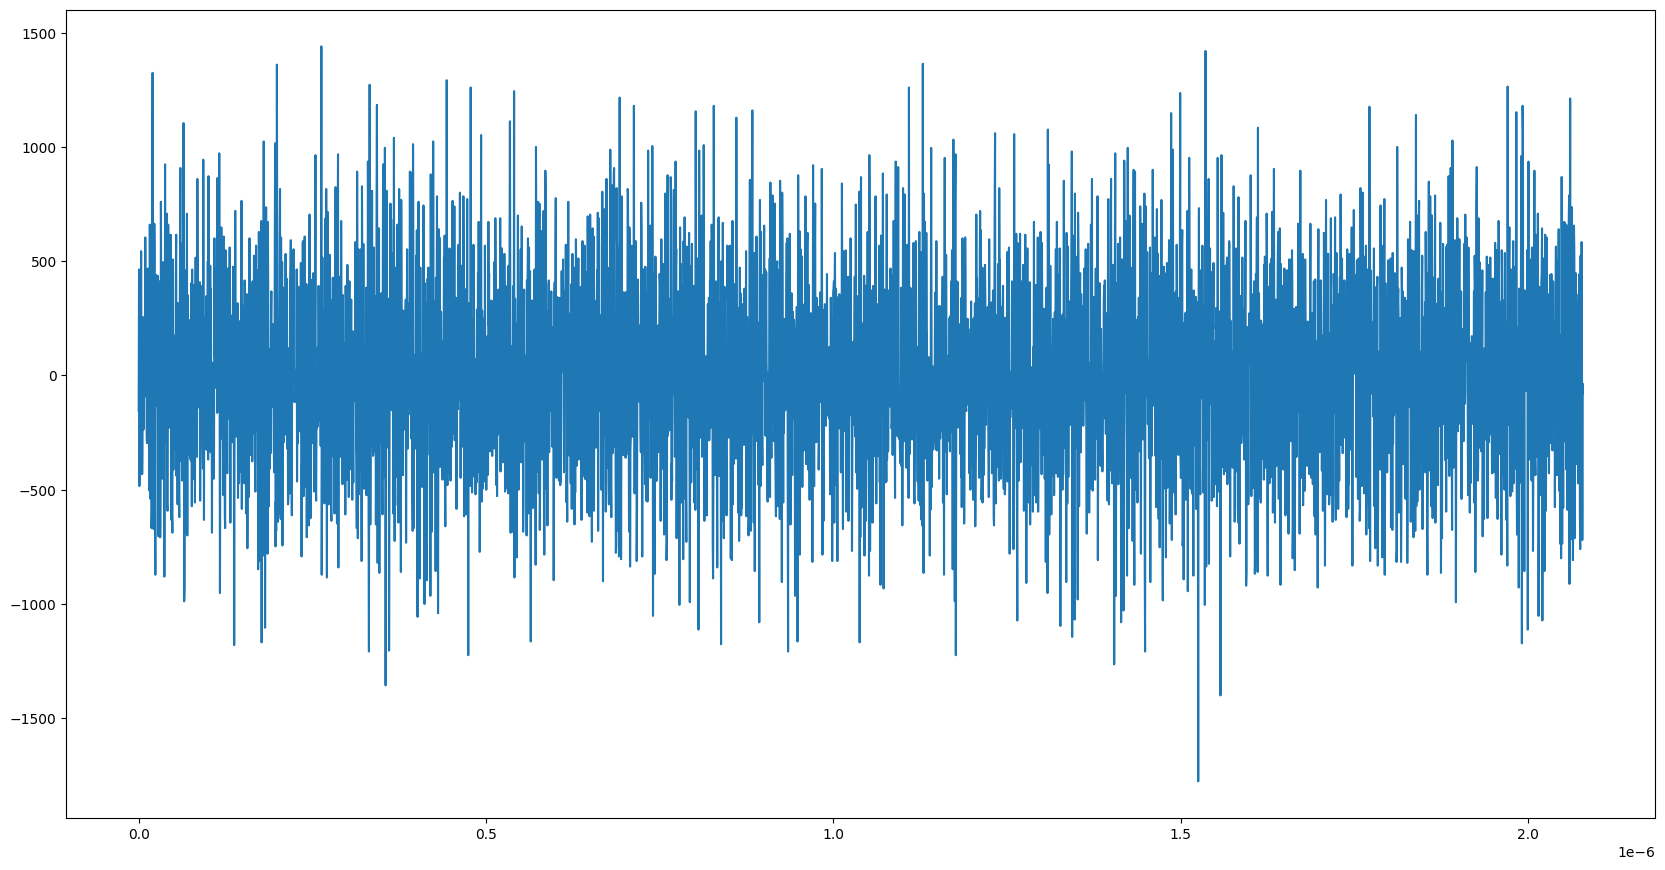

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.gcf().set_size_inches(20.5, 10.5)
plt.plot(np.arange(len(raw_results_no_pulse[0,:]))/sample_rate, raw_results_no_pulse[0,:])
plt.show()

In [10]:
avg_results_no_pulse = raw_results_no_pulse.mean(axis=0) / (2**15)

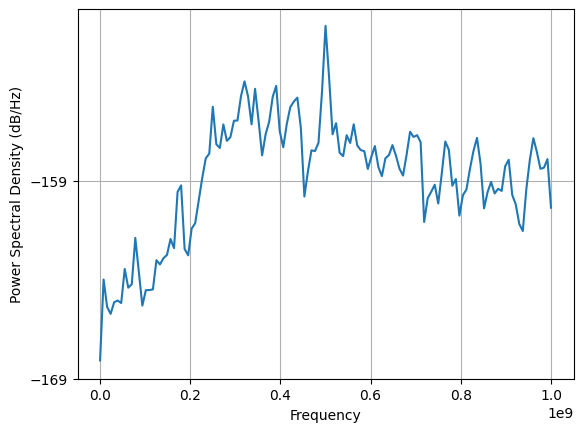

In [11]:
plt.psd(avg_results_no_pulse, Fs=sample_rate)
plt.show()

### Applying a `PULSE` before `RAW-CAPTURE`

Recall how measurements are usually done: first there is a pulse on the `"ro_tx"` frame, and then a capture on the `"ro_rx"` frame. We modify our above program by including the `PULSE` operation associated with the vanilla measurement.

In [12]:
raw_capture_pulse = Program(     
    f'DECLARE raw REAL[{memory_length}]',
    pulse,
    f'RAW-CAPTURE {frame} {duration} raw'
).wrap_in_numshots_loop(1000)
print(raw_capture_pulse)

DECLARE raw REAL[4160]
PULSE 0 "rf_f12" drag_gaussian(alpha: -1.394451807996698, anh: -190000000, detuning: 0, duration: 4e-8, fwhm: 1e-8, phase: 0, scale: 0.28637132443339525, t0: 2e-8)
RAW-CAPTURE 0 "ro_rx" 2.08e-6 raw[0]



In [13]:
exe = qc.compiler.native_quil_to_executable(raw_capture_pulse)
results = qc.run(exe).get_register_map()

raw_results_pulse = results["raw"].reshape(shape)
avg_results_pulse = raw_results_pulse.mean(axis=0) / 2**15

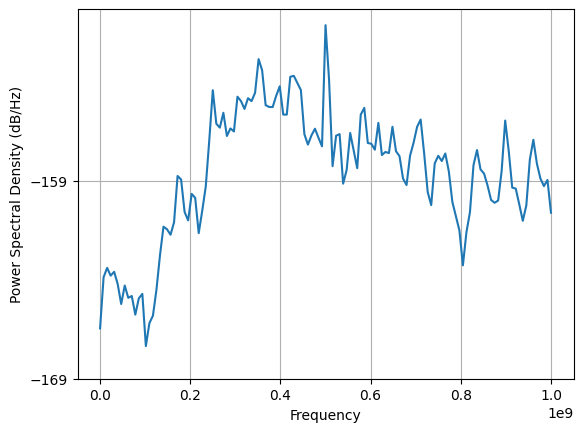

In [14]:
plt.psd(avg_results_pulse, Fs=sample_rate)
plt.show()

### Capturing an excited qubit

Finally, we extend the above by first exciting the qubit, by applying a `RX(pi)` gate.

In [15]:
raw_capture_excited = Program(     
    f'DECLARE raw REAL[{memory_length}]',
    f'RX(pi) {qubit}',
    pulse,
    f'RAW-CAPTURE {frame} {duration} raw'
).wrap_in_numshots_loop(1000)
print(raw_capture_excited)

DECLARE raw REAL[4160]
RX(pi) 0
PULSE 0 "rf_f12" drag_gaussian(alpha: -1.394451807996698, anh: -190000000, detuning: 0, duration: 4e-8, fwhm: 1e-8, phase: 0, scale: 0.28637132443339525, t0: 2e-8)
RAW-CAPTURE 0 "ro_rx" 2.08e-6 raw[0]



In [16]:
exe = qc.compiler.native_quil_to_executable(raw_capture_excited)
results = qc.run(exe).get_register_map()

raw_results_excited = results["raw"].reshape(shape)
avg_results_excited = raw_results_excited.mean(axis=0) / 2**15

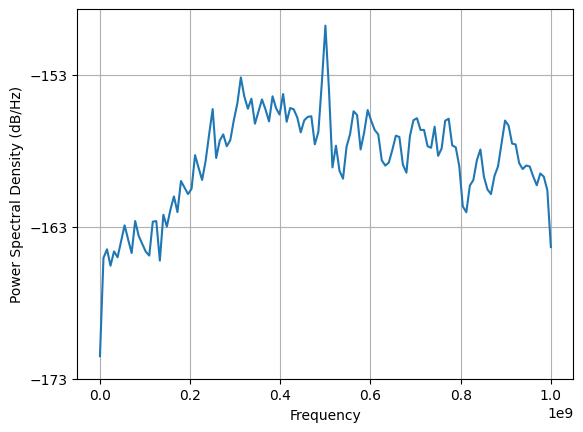

In [17]:
plt.psd(avg_results_excited, Fs=sample_rate)
plt.show()

## Some Restrictions May Apply

Performing a `RAW-CAPTURE` operation places a number of demands on the underlying hardware, and thus comes with a few constraints. We demonstrate these here.

### Capture duration exceeds maximum length

A `RAW-CAPTURE` operation can capture at most 8192 samples per shot, which puts a limit of $\frac{8192}{f_s}$ seconds for the duration, where $f_s$ is the frame's sample rate.

In [18]:
duration = 5e-6
samples = ceil(sample_rate*duration)
rrr = Program(
    f'DECLARE raw REAL[{samples}]', 
    f'RAW-CAPTURE 0 "ro_rx" {duration} raw'
).wrap_in_numshots_loop(1)

try:
    exe = qc.compiler.native_quil_to_executable(rrr)
except Exception as e:
    print(e)

Could not translate quil: Call failed during gRPC request: status: InvalidArgument, message: "RAW-CAPTURE 0 \"ro_rx\" 5e-06 raw[0] would require 10000 samples, butat most 8192 are allowed. Consider using a duration of < 4.096e-06 seconds.", details: [], metadata: MetadataMap { headers: {"server": "awselb/2.0", "date": "Fri, 15 Sep 2023 19:18:38 GMT", "content-type": "application/grpc", "content-length": "0", "x-request-id": "5fbba182-ec44-42f4-98e2-dfb66579855e"} }


### Number of samples in a job exceeds maximum

There is a total limit of $2^{24}$ samples per job, i.e. `duration * sample_rate * num_shots` cannot exceed $2^24$.

In [19]:
duration = 1e-06
samples = ceil(sample_rate*duration)
rrr = Program(
    f'DECLARE raw REAL[{samples}]', 
    f'RAW-CAPTURE 0 "ro_rx" {duration} raw'
).wrap_in_numshots_loop(100000)

try:
    exe = qc.compiler.native_quil_to_executable(rrr)
except Exception as e:
    print(e)

Could not translate quil: Call failed during gRPC request: status: InvalidArgument, message: "RAW-CAPTURE would require DMA buffer of size 381.4697265625 MB but the maximum allowed is 32.0 MB.\nFor duration 1e-06 seconds this places a limit of at most 8388 shots.", details: [], metadata: MetadataMap { headers: {"server": "awselb/2.0", "date": "Fri, 15 Sep 2023 19:18:40 GMT", "content-type": "application/grpc", "content-length": "0", "x-request-id": "a2f6b074-a4e5-4860-bfbb-182f41d6cb48"} }


### `RAW-CAPTURE` precludes the use of other capture operations

Due to the hardware requirements associated with `RAW-CAPTURE`, the following limits are currently imposed:

* there can be at most one `RAW-CAPTURE` operation per program, and
* if a program includes `RAW-CAPTURE`, then it cannot also include `CAPTURE` operations.

In [20]:
duration = 1e-06
samples = ceil(sample_rate*duration)
rrr = Program(
    f'DECLARE raw REAL[{samples}]', 
    'DECLARE ro BIT',
    'MEASURE 1 ro',
    f'RAW-CAPTURE 0 "ro_rx" {duration} raw'
)

try:
    exe = qc.compiler.native_quil_to_executable(rrr)
except Exception as e:
    print(e)

Could not translate quil: Call failed during gRPC request: status: InvalidArgument, message: "Capture conflict: RAW-CAPTURE 0 \"ro_rx\" 1e-06 raw[0] precludes the presence of any other capture instructions, but NONBLOCKING CAPTURE 1 \"ro_rx\" boxcar_kernel(duration: 1.52e-06, scale: 1.0, phase: 1.4934349033969623, detuning: 0.0) q1_unclassified[0] was observed.", details: [], metadata: MetadataMap { headers: {"server": "awselb/2.0", "date": "Fri, 15 Sep 2023 19:18:42 GMT", "content-type": "application/grpc", "content-length": "0", "x-request-id": "a0875784-b6b9-4b97-8c04-39cffd3ec53c"} }
